# Machine Learning Assigment

- Student Name: Tran Nhat Linh (LinhTN18)
- Class: AICamp Batch 6
- Instructor Name: Nguyen Viet Bac (BacNV6)





# Introduce and Project Aim

Airbnb is a home-sharing platform that allows home-owners and renters ('hosts') to put their properties ('listings') online, so that guests can pay to stay in them.

This project aims to use machine learning to predict the base price for properties in Amsterdam, and also to explore Airbnb listing data, in order to help Airbnb hosts maximise their earnings.

# The datasets

The dataset used for this project comes from [Insideairbnb.com](https://insideairbnb.com/), an anti-Airbnb lobby group that scrapes Airbnb listings, reviews and calendar data for multiple cities around the world.

Inside Airbnb Data Dictionary: 
https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=982310896

In [ ]:
%%writefile links.txt
http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2021-03-04/data/listings.csv.gz
http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2021-06-03/data/listings.csv.gz
http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2021-09-07/data/listings.csv.gz
http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2021-12-05/data/listings.csv.gz

http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2021-03-04/data/calendar.csv.gz
http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2021-06-03/data/calendar.csv.gz
http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2021-09-07/data/calendar.csv.gz
http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2021-12-05/data/calendar.csv.gz

http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2021-03-04/data/reviews.csv.gz
http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2021-06-03/data/reviews.csv.gz
http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2021-09-07/data/reviews.csv.gz
http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2021-12-05/data/reviews.csv.gz

Writing links.txt


In [ ]:
# ! wget -i links.txt

# Setup libraries and function




In [ ]:
# Common imports
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import os 
from sklearn.metrics import mean_absolute_error
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    try:
        plt.savefig(path, format=fig_extension, dpi=resolution)
    except:
        plt.savefig(fig_id + "." + fig_extension, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
pd.options.display.max_columns = None


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Preprocessing Data & Cleaning

In [ ]:
listings_March = pd.read_csv("/content/drive/MyDrive/airbnb/listings.csv")
listings_June = pd.read_csv("/content/drive/MyDrive/airbnb/listings_1.csv")
listings_September = pd.read_csv("/content/drive/MyDrive/airbnb/listings_2.csv")
listings_December = pd.read_csv("/content/drive/MyDrive/airbnb/listings_3.csv")

calendar_March = pd.read_csv("/content/drive/MyDrive/airbnb/calendar.csv")
calendar_June = pd.read_csv("/content/drive/MyDrive/airbnb/calendar_1.csv")
calendar_September = pd.read_csv("/content/drive/MyDrive/airbnb/calendar_2.csv")
calendar_December = pd.read_csv("/content/drive/MyDrive/airbnb/calendar_3.csv")

reivew_March = pd.read_csv("/content/drive/MyDrive/airbnb/reviews.csv")
reivew_June = pd.read_csv("/content/drive/MyDrive/airbnb/reviews_1.csv")
reivew_September = pd.read_csv("/content/drive/MyDrive/airbnb/reviews_2.csv")
reivew_December = pd.read_csv("/content/drive/MyDrive/airbnb/reviews_3.csv")

In [ ]:
listings_list = [listings_March, listings_June, listings_September, listings_December]
calendar_list = [calendar_March, calendar_June, calendar_September, calendar_December]
review_list = [reivew_March, reivew_June, reivew_September, reivew_December]

listings = pd.concat(listings_list)
calendar = pd.concat(calendar_list)
review = pd.concat(review_list)

In [ ]:
# checking the number of rows and columns in each dataframe

print("Shape of listings df:", listings.shape)
print("Shape of calendar df:", calendar.shape)
print("Shape of reviews df:", review.shape)

Shape of listings df: (56846, 74)
Shape of calendar df: (20746026, 7)
Shape of reviews df: (1518086, 6)


In [ ]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20210304032253,2021-03-06,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi<br />...,"Indische Buurt (""Indies Neighborhood"") is a ne...",https://a0.muscache.com/pictures/10272854/8dcc...,3159,https://www.airbnb.com/users/show/3159,Daniel,2008-09-24,"Amsterdam, Noord-Holland, The Netherlands","Upon arriving in Amsterdam, one can imagine as...",NaN,NaN,100%,t,https://a0.muscache.com/im/users/3159/profile_...,https://a0.muscache.com/im/users/3159/profile_...,Indische Buurt,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Amsterdam, North Holland, Netherlands",Oostelijk Havengebied - Indische Buurt,NaN,52.36575,4.94142,Private room in apartment,Private room,2,NaN,1.5 shared baths,1.0,2.0,"[""Essentials"", ""Lock on bedroom door"", ""Hot wa...",$59.00,3,1125,3.0,3.0,1125.0,1125.0,3.0,1125.0,NaN,t,19,35,60,139,2021-03-06,278,0,0,2009-03-30,2020-02-14,98.0,10.0,10.0,10.0,10.0,9.0,10.0,NaN,t,1,0,1,0,1.91
1,20168,https://www.airbnb.com/rooms/20168,20210304032253,2021-03-05,Studio with private bathroom in the centre 1,17th century Dutch townhouse in the heart of t...,Located just in between famous central canals....,https://a0.muscache.com/pictures/69979628/fd6a...,59484,https://www.airbnb.com/users/show/59484,Alexander,2009-12-02,"Amsterdam, Noord-Holland, The Netherlands",+ (Phone number hidden by Airbnb),NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/65092...,https://a0.muscache.com/im/pictures/user/65092...,Grachtengordel,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Amsterdam, North Holland, Netherlands",Centrum-Oost,NaN,52.36509,4.89354,Private room in townhouse,Private room,2,NaN,1 private bath,1.0,1.0,"[""Essentials"", ""Wifi"", ""Paid parking off premi...",$149.00,1,365,1.0,4.0,365.0,1125.0,3.6,475.3,NaN,t,0,0,0,0,2021-03-05,339,11,0,2010-03-02,2020-04-09,89.0,10.0,10.0,10.0,10.0,10.0,9.0,NaN,t,2,0,2,0,2.53
2,25428,https://www.airbnb.com/rooms/25428,20210304032253,2021-03-06,"Lovely, spacious 1 bed apt in Center(with lift)",Lovely apt in Centre ( lift & fireplace) near ...,NaN,https://a0.muscache.com/pictures/138431/7079a9...,56142,https://www.airbnb.com/users/show/56142,Joan,2009-11-20,"New York, New York, United States","We are a retired couple who live in NYC, and h...",within a few hours,100%,0%,t,https://a0.muscache.com/im/users/56142/profile...,https://a0.muscache.com/im/users/56142/profile...,Grachtengordel,2.0,2.0,"['email', 'phone', 'reviews']",t,f,NaN,Centrum-West,NaN,52.37297,4.88339,Entire apartment,Entire home/apt,3,NaN,1 bath,1.0,1.0,"[""Essentials"", ""Hot water"", ""Microwave"", ""Dish...",$125.00,14,18

In [ ]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,451719,2021-03-05,t,$190.00,$190.00,3.0,60.0
1,230710,2021-03-05,f,$125.00,$125.00,14.0,60.0
2,230710,2021-03-06,f,$125.00,$125.00,14.0,60.0
3,230710,2021-03-07,f,$125.00,$125.00,14.0,60.0
4,230710,2021-03-08,f,$125.00,$125.00,14.0,60.0


In [ ]:
review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1,2818,1771,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
2,2818,1989,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
3,2818,2797,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
4,2818,3151,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


In [ ]:
# Importing regex
import re

bath = ["bathrooms_text"]
for col in bath:
    listings[col] = listings[col].apply(lambda x: str(re.compile('[a-zA-Z]').sub('', str(x))))
    listings[col] = listings[col].apply(lambda x: str(re.compile(' ').sub('', str(x))))

In [ ]:
listings["bathrooms"] = pd.to_numeric(listings["bathrooms_text"],errors='coerce')

In [ ]:
listings.drop(['bathrooms_text'], axis=1, inplace=True)

In [ ]:
# The price fields in our data frame
price_list = ["price"]

# We change any blanks to 0 and use our regex function to remove anything that isn't a number (or negative number which is changed to 0)
for col in price_list:
    listings[col] = listings[col].fillna("0")
    listings[col] = listings[col].apply(lambda x: float(re.compile('[^0-9eE.]').sub('', x)) if len(x)>0 else 0)

In [ ]:
listings['host_since'] = pd.to_datetime(listings['host_since'])

## Drop initial column



The free text columns will be dropped for now, as will other columns which are not useful for predicting price (e.g. url, host name and other host-related features that are unrelated to the property).

In [ ]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
listings = listings.drop(cols_to_drop, axis=1)

In [ ]:
listings.isna().sum()

id                                                  0
host_since                                        138
host_response_time                              39540
host_response_rate                              39540
host_acceptance_rate                            36034
host_is_superhost                                 138
host_listings_count                               138
host_total_listings_count                         138
host_has_profile_pic                              138
host_identity_verified                            138
neighbourhood                                   19471
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                    56846
latitude                                            0
longitude                                           0
property_type                                       0
room_type                                           0
accommodates                                        0
bathrooms                   

Other columns can be dropped because they contain a majority of null entries.

In [ ]:
listings.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'license'], axis=1, inplace=True)

listings.set_index('id', inplace=True) # The id will be used as the index, as this could be useful in future e.g. if a separate dataset containing reviews for each property is linked to this one

`host_listings_count` and `host_total_listings_count` are the same in all but 138 cases. These cases are those where the value is NaN. Therefore one of these columns can be dropped. Other columns which split these into type of property will also be dropped, as they will be highly correlated (one will be the total of the others).

In [ ]:
print(sum((listings.host_listings_count == listings.host_total_listings_count) == False))
listings.loc[((listings.host_listings_count == listings.host_total_listings_count) == False)][:5]

138


,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
571029,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Amsterdam, North Holland, Netherlands",De Baarsjes - Oud-West,52.36840,4.86064,Entire apartment,Entire home/apt,4,1.0,2.0,2.0,"[""Essentials"", ""Hot water"", ""High chair"", ""Car...",150.0,3,1124,3.0,3.0,1124.0,1124.0,3.0,1124.0,NaN,t,0,0,0,0,10,0,0,2012-08-13,2018-05-27,98.0,10.0,9.0,10.0,10.0,9.0,9.0,f,52,52,0,0,0.10
996112,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Centrum-Oost,52.36375,4.88486,Entire apartment,Entire home/apt,4,1.0,2.0,4.0,"[""Essentials"", ""Wifi"", ""TV"", ""Shampoo"", ""Cable...",300.0,3,21,3.0,3.0,21.0,21.0,3.0,21.0,NaN,t,0,0,0,0,19,0,0,2013-05-13,2019-04-21,94.0,9.0,9.0,10.0,10.0,10.0,9.0,f,1,1,0,0,0.20
1364081,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Amsterdam, North Holland, Netherlands",Oostelijk Havengebied - Indische Buurt,52.36304,4.93673,Entire apartment,Entire home/apt,3,1.0,1.0,2.0,"[""Essentials"", ""Hot water"", ""Microwave"", ""Dish...",135.0,3,1124,3.0,3.0,1124.0,1124.0,3.0,1124.0,NaN,t,0,0,0,0,56,0,0,2013-08-31,2018-08-27,88.0,9.0,8.0,9.0,9.0,9.0,9.0,f,52,52,0,0,0.61
1849795,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Amsterdam, North Holland, Netherlands",Centrum-West,52.37375,4.87929,Entire apartment,Entire home/apt,2,1.0,1.0,1.0,"[""Essentials"", ""Hot water"", ""Microwave"", ""Dish...",126.0,3,1125,3.0,3.0,1125.0,1125.0,3.0,1125.0,NaN,t,0,0,0,0,39,0,0,2013-11-03,2018-12-16,91.0,9.0,9.0,10.0,9.0,10.0,9.0,f,52,52,0,0,0.44
2961379,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oud-Oost,52.35269,4.91307,Entire apartment,Entire home/apt,2,1.0,2.0,1.0,"[""Essentials"", ""Hot water"", ""High chair"", ""Car...",119.0,2,16,2.0,2.0,16.0,16.0,2.0,16.0,NaN,t,0,0,0,0,17,0,0,2014-07-22,2020-01-02,95.0,10.0,9.0,10.0,10.0,10.0,9.0,f,2,2,0,0,0.21


In [ ]:
listings.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
               'calculated_host_listings_count_private_rooms', 
               'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

There are multiple columns for minimum and maximum night stays, but the two main ones will be used as there are few differences between e.g. minimum_nights and minimum_minimum_nights. The latter presumably refers to the fact that min/max night stays can vary over the year. The default (i.e. most frequently applied) min/max night stay values will be used instead.

In [ ]:
sum((listings.minimum_nights == listings.minimum_minimum_nights) == False)

2042

In [ ]:
listings.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

Checking whether boolean and categorical features contain sufficient numbers of instances in each category to make them worth including:

In [ ]:
# Replacing columns with f/t with 0/1
listings.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
#listings.hist(figsize=(20,20));

From the above, it can be seen that several columns only contain one category and can be dropped:

In [ ]:
listings.drop(['has_availability','host_has_profile_pic'], axis=1, inplace=True)

These will be highly correlated with number_of_reviews and so will be dropped.

In [ ]:
listings.drop(['number_of_reviews_ltm','number_of_reviews_l30d', 'reviews_per_month'], axis=1, inplace=True)

There are multiple different measures of availability, which will be highly correlated with each other. Only one will be retained - for 90 days. This is because in Amsterdam it is illegal to have short-term (e.g. Airbnb) guests paying to stay in your property for more than 90 days each calendar year, so this is the maximum that should theoretically be possible.

In [ ]:
listings.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

In [ ]:
listings.dtypes

host_since                     datetime64[ns]
host_response_time                     object
host_response_rate                     object
host_is_superhost                     float64
host_listings_count                   float64
host_identity_verified                float64
neighbourhood                          object
neighbourhood_cleansed                 object
latitude                              float64
longitude                             float64
property_type                          object
room_type                              object
accommodates                            int64
bathrooms                             float64
bedrooms                              float64
beds                                  float64
amenities                              object
price                                 float64
minimum_nights                          int64
maximum_nights                          int64
calendar_updated                      float64
availability_90                   

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80079c2190>,
      dtype=object)

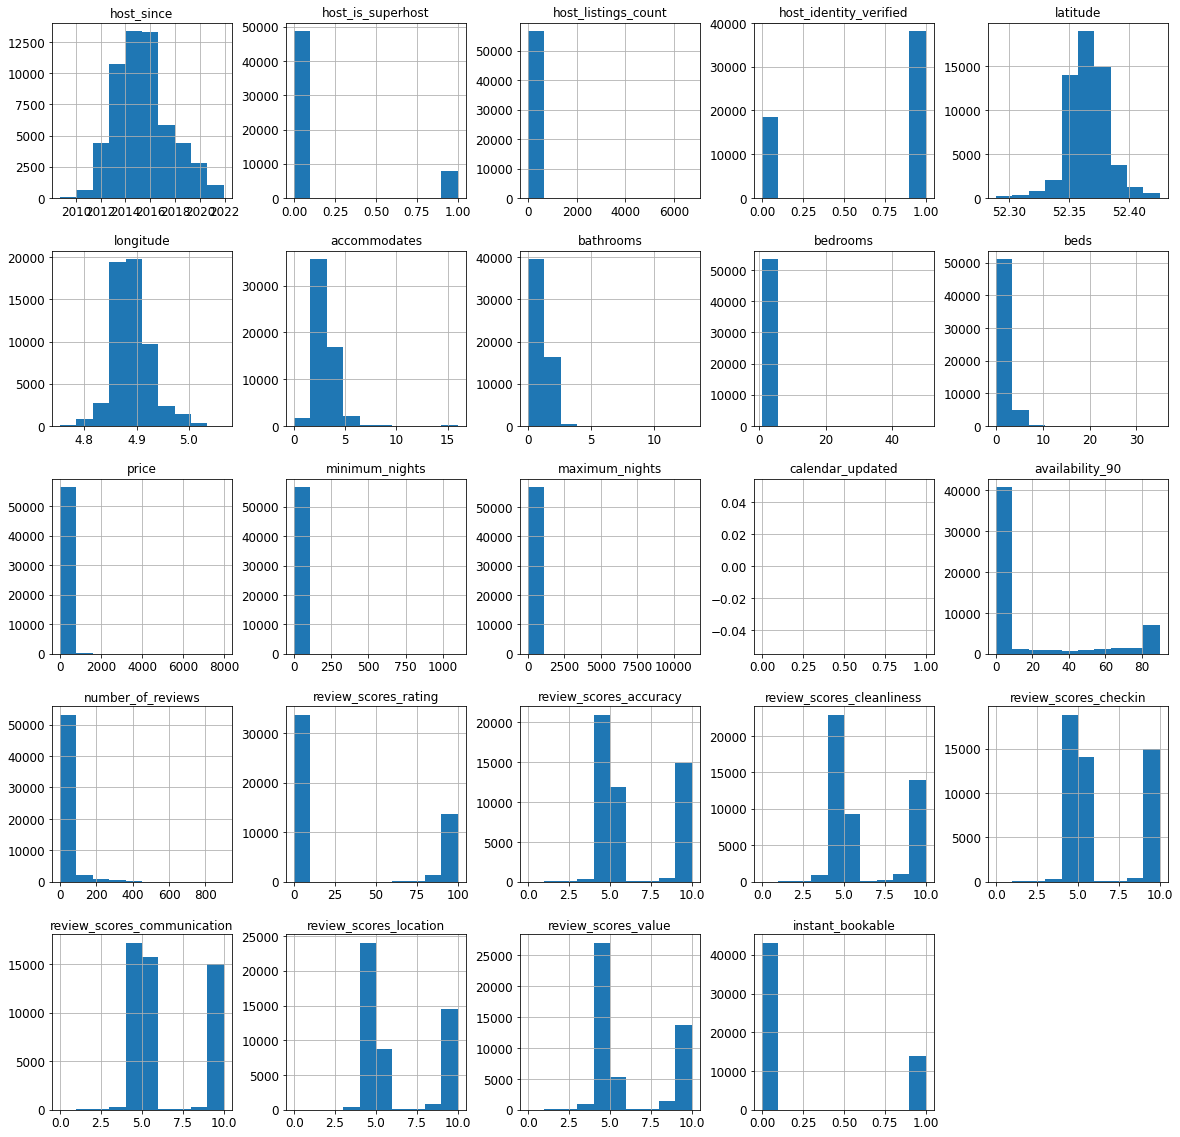

In [ ]:
# Plotting the distribution of numerical and boolean categories
listings.hist(figsize=(20,20))

## Cleaning individuals columns

### **Host since**

*The date that the host first joined Airbnb*



This is a datetime column, and will be converted into a measure of the number of days that a host has been on the platform, measured from the date that the data was scraped (5 March 2021). The original column will be left in initially for EDA, and dropped later.

In [ ]:
# Converting to datetime
listings.host_since = pd.to_datetime(listings.host_since) 

# Calculating the number of days
listings['host_days_active'] = (datetime(2021, 12, 31) - listings.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(listings['host_days_active'].mean(),0))
print("Median days as host:", listings['host_days_active'].median())

# Replacing null values with the median
listings.host_days_active.fillna(listings.host_days_active.median(), inplace=True)

Mean days as host: 2397.0
Median days as host: 2474.0


### **Host response time**
*The average amount of time the host takes to reply to messages*



About a third of rows don't have a value for host_response_time, and the majority of these have also not yet been reviewed. Therefore this section of the dataset consists primarily of properties which have not yet had a completed stay (most likely properties which have not yet had a booking, although may also include properties that have a booking currently occuring). Although this is a considerable proportion of the dataset, these listings will be retained in the data because they are still legitimate properties with advertised prices, and are still part of the comparative market when considering the price for which to advertise your Airbnb listing. However, if the dataset being used had the actual average price paid as its target, it would be necessary to drop these rows because they would not have a value, as they have not yet been booked.

It is worth noting, however, that this group of listings probably also contains a large number of 'inactive' listings. These are properties which have been speculatively listed on Airbnb but either have their calendars closed (so no stays can be booked), or have prices which are notably higher than other properties in their area. The latter occurs in some cases when people who regularly live in a property put their property on Airbnb at a high price just to see if anyone is willing to book at that price (some Airbnb listings are indeed booked at very high prices). Then if their property is booked, they will decamp to a cheaper hotel for those dates, and pocket the difference in price.

Because host_response_time is unknown for so many listings, it will be retained as its own category, 'unknown'.

In [ ]:
print("Null values:", listings.host_response_time.isna().sum())
print(f"Proportion: {round((listings.host_response_time.isna().sum()/len(listings))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
len(listings[listings.loc[ :,['host_response_time', 'first_review'] ].isnull().sum(axis=1) == 2])

Null values: 39540
Proportion: 69.6%


5306

In [ ]:
listings.host_response_time.fillna("unknown", inplace=True)
listings.host_response_time.value_counts(normalize=True)

unknown               0.695563
within an hour        0.153203
within a day          0.064103
within a few hours    0.062784
a few days or more    0.024346
Name: host_response_time, dtype: float64

In [ ]:
listings.host_response_time.value_counts(normalize=True)

unknown               0.695563
within an hour        0.153203
within a day          0.064103
within a few hours    0.062784
a few days or more    0.024346
Name: host_response_time, dtype: float64

### **Host response rate**
*The proportion of messages that the host replies to*



A similar story is true for host_response_rate, with about a third of values being null. This will also be kept as its own category, after grouping other values into meaningful groups (i.e. transforming this into a categorical feature, rather than a numerical one). Because about 70% of hosts respond 100% of the time, this will be kept as its own category, and other values will be grouped into bins.

In [ ]:
print("Null values:", listings.host_response_rate.isna().sum())
print(f"Proportion: {round((listings.host_response_rate.isna().sum()/len(listings))*100, 1)}%")

Null values: 39540
Proportion: 69.6%


In [ ]:
# Removing the % sign from the host_response_rate string and converting to an integer
listings.host_response_rate = listings.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(listings['host_response_rate'].mean(),0))
print("Median host response rate:", listings['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((listings.host_response_rate == 100.0).sum()/listings.host_response_rate.count())*100,1)}%")

Mean host response rate: 89.0
Median host response rate: 100.0
Proportion of 100% host response rates: 70.4%


In [ ]:
# Bin into four categories
listings.host_response_rate = pd.cut(listings.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
listings.host_response_rate = listings.host_response_rate.astype('str')

# Replace nulls with 'unknown'
listings.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
listings.host_response_rate.value_counts()

unknown    39540
100%       12192
50-89%      2320
0-49%       1754
90-99%      1040
Name: host_response_rate, dtype: int64

### **Host is superhost**

In [ ]:
# Number of rows without a value for multiple host-related columns
len(listings[listings.loc[ :,['host_is_superhost', 'host_listings_count', 'host_identity_verified'] ].isnull().sum(axis=1) == 5])

0

In [ ]:
listings.dropna(subset=['host_since'], inplace=True)

### **Property type**
*The type of property, e.g. house or flat*



Some cleaning of property types is required as there are a large number of categories with only a few listings. The categories 'apartment', 'house' and 'other' will be used, as most properties can be classified as either apartments or houses.

In [ ]:
pd.options.display.max_rows = 10000
listings.property_type.value_counts()

Entire apartment                       21700
Entire rental unit                     12112
Private room in apartment               4248
Private room in rental unit             2438
Entire house                            2278
Entire townhouse                        1500
Entire residential home                 1395
Private room in bed and breakfast       1257
Entire loft                              934
Houseboat                                666
Private room in house                    653
Boat                                     649
Room in boutique hotel                   629
Entire condominium (condo)               627
Private room in townhouse                570
Entire serviced apartment                528
Entire condominium                       509
Private room in houseboat                436
Private room in residential home         427
Private room in guest suite              410
Room in hotel                            404
Private room in boat                     344
Private ro

In [ ]:
# Replacing categories that are types of houses or apartments
listings.property_type.replace({
    'Entire apartment': 'Apartment',
    'Entire rental unit':'Apartment',
    'Entire serviced apartment': 'Apartment',
    'Entire loft': 'Apartment',
    'Entire guesthouse':'House',
    'Entire house': 'House',
    'Entire townhouse':'House',
    'Entire residential home': 'House',
    'Houseboat':'House',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Entire villa': 'House',
    'Entire guesthouse':'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
listings.loc[~listings.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

**bathrooms, bedrooms and beds**

Missing values will be replaced with the median (to avoid strange fractions).

In [ ]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    listings[col].fillna(listings[col].median(), inplace=True)

### **Amenities**

Amenities is a list of additional features in the property, e.g. whether it has a TV or parking. Examples are below:

In [ ]:
listings.amenities[:2].values

array(['["Essentials", "Lock on bedroom door", "Hot water", "Carbon monoxide alarm", "Host greets you", "Garden or backyard", "Shampoo", "Single level home", "Extra pillows and blankets", "Hangers", "Washer", "Dedicated workspace", "Iron", "Paid parking off premises", "Paid parking on premises", "Smoke alarm", "Hair dryer", "Refrigerator", "Wifi", "Ethernet connection", "Long term stays allowed", "Heating", "First aid kit", "Bed linens", "Coffee maker", "Fire extinguisher", "Private entrance"]',
       '["Essentials", "Wifi", "Paid parking off premises", "Free street parking", "TV", "Hot water", "Heating", "Long term stays allowed", "Bed linens", "Smoke alarm", "Carbon monoxide alarm", "Hair dryer", "Hangers", "Fire extinguisher", "Refrigerator", "Host greets you", "Dedicated workspace"]'],
      dtype=object)

In [ ]:
# Creating a set of all possible amenities
amenities_list = list(listings.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('[', '')
amenities_list_string = amenities_list_string.replace(']', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_list_string = amenities_list_string.replace('', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 'Bora induction stove',
 'eco shampoo',
 'standard body soap',
 'Shower gel',
 'Harman Kardon sound system with aux',
 'AESOP conditioner',
 'Several  body soap',
 'Dishes and silverware',
 'Bosch Single Oven Fan Assist oven',
 "Aunt Jackie's shampoo",
 'O shampoo',
 'Private gym',
 'Piano',
 'BOSE Bluetooth sound system',
 'organic soap body soap',
 'mail oven',
 'Wine glasses',
 'Stainless steel gas stove',
 'Sonos Bluetooth sound system',
 'SMEG refrigerator',
 'Kupperbusch refrigerator',
 'HDTV',
 'divers shampoo',
 'R/ CDplayer sound system',
 'Clothing storage: walk-in closet and closet',
 '32\\ HDTV with standard cable',
 'Sony sound system with aux',
 'Onbekend  body soap',
 'KEF Bluetooth sound system',
 '55\\ HDTV with Chromecast',
 'Marie Stella Maris luxury brand body soap',
 'L\\u2019Or\\u00e9al Elvive shampoo',
 'Amsterdamsche Zeepfabriek body soap',
 '36\\ HDTV with Amazon Prime Video',
 'Fast wifi \\u2013 203 Mbps',
 'Divers body soap',
 'Baking sheet',
 'Hotel So

In [ ]:
len(amenities_set)

1059

In [ ]:
listings.loc[listings['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
listings.loc[listings['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
listings.loc[listings['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
listings.loc[listings['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
listings.loc[listings['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
listings.loc[listings['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
listings.loc[listings['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
listings.loc[listings['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
listings.loc[listings['amenities'].str.contains('TV'), 'tv'] = 1
listings.loc[listings['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
listings.loc[listings['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
listings.loc[listings['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
listings.loc[listings['amenities'].str.contains('Elevator'), 'elevator'] = 1
listings.loc[listings['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
listings.loc[listings['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
listings.loc[listings['amenities'].str.contains('parking'), 'parking'] = 1
listings.loc[listings['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
listings.loc[listings['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
listings.loc[listings['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
listings.loc[listings['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
listings.loc[listings['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
listings.loc[listings['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
listings.loc[listings['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
listings.loc[listings['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
listings.loc[listings['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
listings.loc[listings['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
listings.loc[listings['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
listings.loc[listings['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [ ]:
listings.head()

,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,calendar_updated,availability_90,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,host_days_active,check_in_24h,air_conditioning,high_end_electronics,bbq,balcony,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,child_friendly,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,accessible,event_suitable
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2818,2008-09-24,unknown,unknown,1.0,1.0,1.0,"Amsterdam, North Holland, Netherlands",Oostelijk Havengebied - Indische Buurt,52.36575,4.94142,Other,Private room,2,1.5,1.0,2.0,"[""Essentials"", ""Lock on bedroom door"", ""Hot wa...",59.0,3,1125,NaN,60,278,2009-03-30,2020-02-14,98.0,10.0,10.0,10.0,10.0,9.0,10.0,1,4846.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
20168,2009-12-02,unknown,unknown,0.0,2.0,1.0,"Amsterdam, North Holland, Netherlands",Centrum-Oost,52.36509,4.89354,Other,Private room,2,1.0,1.0,1.0,"[""Essentials"", ""Wifi"", ""Paid parking off premi...",149.0,1,365,NaN,0,339,2010-03-02,2020-04-09,89.0,10.0,10.0,10.0,10.0,10.0,9.0,1,4412.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25428,2009-11-20,within a few hours,100%,1.0,2.0,0.0,NaN,Centrum-West,52.37297,4.88339,Apartment,Entire home/apt,3,1.0,1.0,1.0,"[""Essentials"", ""Hot water"", ""Microwave"", ""Dish...",125.0,14,180,NaN,89,5,2018-01-21,2020-02-09,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,4424.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27886,2010-03-23,within an hour,100%,1.0,1.0,1.0,"Amsterdam, North Holland, Netherlands",Centrum-West,52.38761,4.89188,Other,Private room,2,1.5,1.0,1.0,"[""Essentials"", ""Hot water"", ""Carbon monoxide a...",123.0,2,730,NaN,1,219,2012-01-09,2020-07-25,99.0,10.0,10.0,10.0,10.0,10.0,10.0,1,4301.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
28871,2010-05-13,within an hour,100%,1.0,2.0,1.0,"Amsterdam, North Holland, Netherlands",Centrum-Oost,52.36610,4.88953,Other,Private room,2,1.0,1.0,1.0,"[""Essentials"", ""Wifi"", ""Lock on bedroom door"",...",75.0,2,1825,NaN,76,336,2010-08-22,2020-09-20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,4250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
listings.iloc[:,32:].columns

Index(['coffee_machine', 'cooking_basics', 'white_goods', 'child_friendly',
       'parking', 'host_greeting', 'internet', 'long_term_stays',
       'private_entrance', 'time_since_first_review',
       'time_since_last_review'],
      dtype='object')

In [ ]:
# # Replacing nulls with zeros for new columns
cols_to_replace_nulls = listings.iloc[:,32:].columns
listings[cols_to_replace_nulls] = listings[cols_to_replace_nulls].fillna(0)

# # Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in listings.iloc[:,32:].columns:
    if listings[col].sum() < len(listings)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# # Dropping infrequent amenity features
# listings.drop(infrequent_amenities, axis=1, inplace=True)

# # Dropping the original amenity feature
# listings.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'air_conditioning', 'high_end_electronics', 'bbq', 'nature_and_views', 'breakfast', 'elevator', 'gym', 'outdoor_space', 'hot_tub_sauna_or_pool', 'pets_allowed', 'secure', 'self_check_in', 'smoking_allowed', 'accessible', 'event_suitable']


In [ ]:
listings.drop(infrequent_amenities, axis=1, inplace=True)

In [ ]:
listings.drop('amenities', axis=1, inplace=True)

In [ ]:
print("Number of categories:", listings.calendar_updated.nunique())
print("\nTop five categories:")
listings.calendar_updated.value_counts()[:5]

Number of categories: 0

Top five categories:


Series([], Name: calendar_updated, dtype: int64)

In [ ]:
listings.drop('calendar_updated', axis=1, inplace=True)

### **First review and last review**

*the date of the first review and the date of the most recent review*



About a quarter of listings have not had a review written for them. This is too large a proportion of the dataset to drop, and dropping the columns would lose a lot of useful information - reviews are very important in people's decisions to book, and therefore price.

This is also too large a proportion of the dataset to simply replace with median/mean values, as this would skew the distribution substantially. Also, the missing values here are not really missing values, as the fact that they are NaNs is meaningful - it tells us that these are new or previously unbooked listings that have not had reviews yet. In order to make the resulting model work able to predict prices for any Airbnb listing, including brand new listings, is is actually beneficial to keep them in. Therefore, these will be kept as an 'unknown' category, and the feature will have to be treated as categorical (and therefore one-hot encoded) rather than numerical.

In [ ]:
print(f"Null values in 'first_review': {round(100*listings.first_review.isna().sum()/len(listings),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*listings.review_scores_rating .isna().sum()/len(listings),1)}%")

Null values in 'first_review': 12.8%
Null values in 'review_scores_rating': 13.3%


In [ ]:
listings.first_review = pd.to_datetime(listings.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
listings['time_since_first_review'] = (datetime(2021, 12, 31) - listings.first_review).astype('timedelta64[D]')

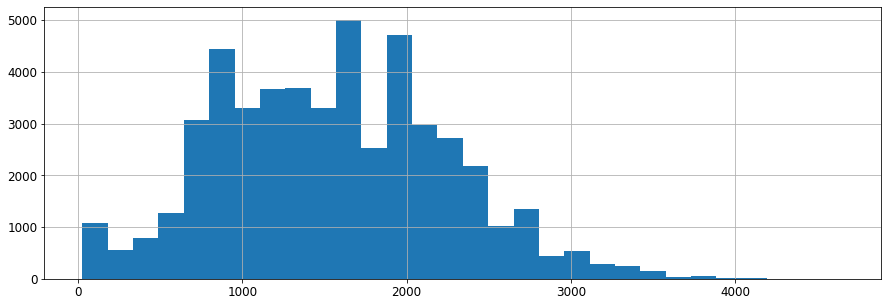

In [ ]:
# Distribution of the number of days since first review
listings.time_since_first_review.hist(figsize=(15,5), bins=30);

In [ ]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    listings[col] = pd.cut(listings[col], bins=bins, labels=labels, include_lowest=True)
    listings[col] = listings[col].astype('str')
    listings[col].fillna(na_label, inplace=True)

In [ ]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(listings.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

In [ ]:
listings.last_review = pd.to_datetime(listings.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
listings['time_since_last_review'] = (datetime(2021, 12, 31) - listings.last_review).astype('timedelta64[D]')

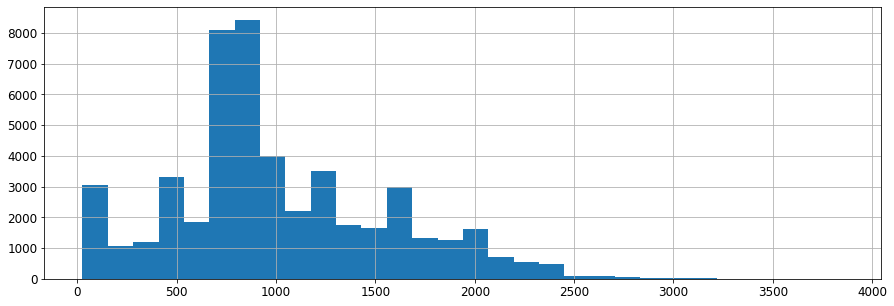

In [ ]:
# Distribution of the number of days since last review
listings.time_since_last_review.hist(figsize=(15,5), bins=30);

In [ ]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(listings.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [ ]:
# Dropping last_review - first_review will be kept for EDA and dropped later
listings.drop('last_review', axis=1, inplace=True)

### **Review ratings columns**

- review_scores_rating - guests can score properties overall from 1 to 5 stars
- review_scores_accuracy - guests can score the accuracy of a property's description from 1 to 5 stars
- review_scores_cleanliness - guests can score a property's cleanliness from 1 to 5 stars
- review_scores_checkin - guests can score their check-in from 1 to 5 stars
- review_scores_communication - guests can score a host's communication from 1 to 5 stars
- review_scores_location - guests can score a property's location from 1 to 5 stars
- review_scores_value - guests can score a booking's value for money from 1 to 5 stars
- reviews_per_month - calculated field of the average number of reviews left by guest each month



As above, listings without reviews will be kept and replaced with 'unknown'. Other ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins. The majority of ratings are 9 or 10 out of 10, as also seen in the value count below. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together (as this is, by Airbnb standards, a 'low' rating).

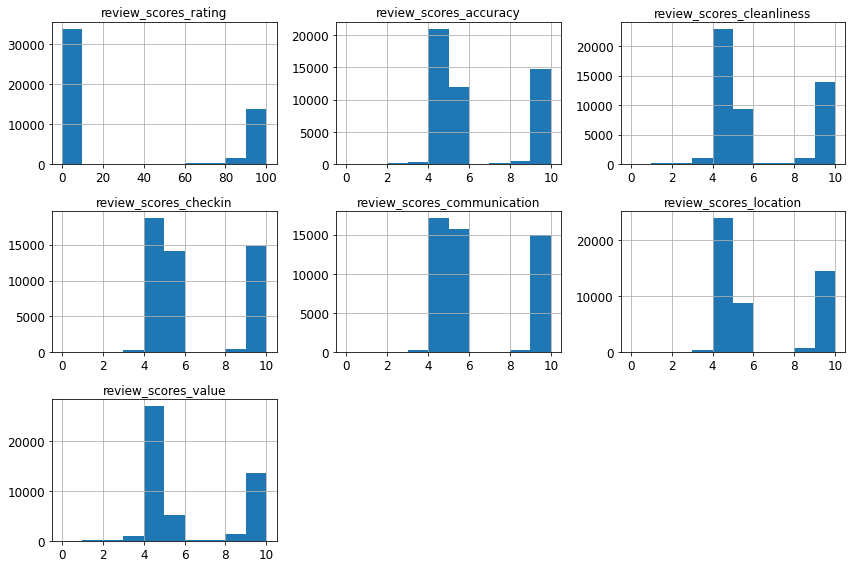

In [ ]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(listings.columns[listings.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    listings[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [ ]:
variables_to_plot.pop(0)

'review_scores_rating'

In [ ]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [ ]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

# EDA

## Time Series

#### *Question: how long have hosts been listing properties on Airbnb in Amsterdam?*

Answer: 

the oldest Netherlands listing that is currently live on Airbnb was first listed on the site in August 2008. From 2011 onwards, the number of listings started increasing considerably. However, growth in the number of new hosts (of those currently listing on the site) has been decreasing since 2015, when the UK government introduced a law in 2015 making it illegal to let short-term residential properties for more than 90 nights a year.

A high level of seasonality is evident, with notable peaks in the summer when people put properties online to take advantage of the increased number of tourists in the summer holidays.

There is a big peak in the number of hosts joining Airbnb in 2015. This could be a response to the government legislation, as existing hosts may have created new accounts in order to re-list their properties and get around the 90 day limit.

In [ ]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(listings.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(listings.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 24 September 2008, and the most recent joined on 04 December 2021.


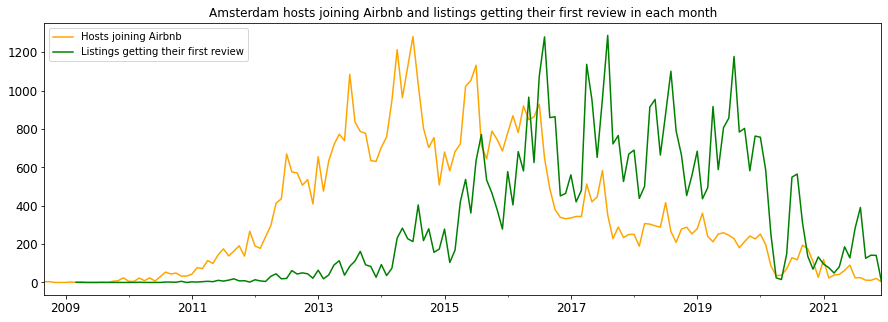

In [ ]:
plt.figure(figsize=(15,5))
listings.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
listings.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='green')
plt.title('Amsterdam hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2008-09-01', '2021-12-31') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(listings.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(listings.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [ ]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)

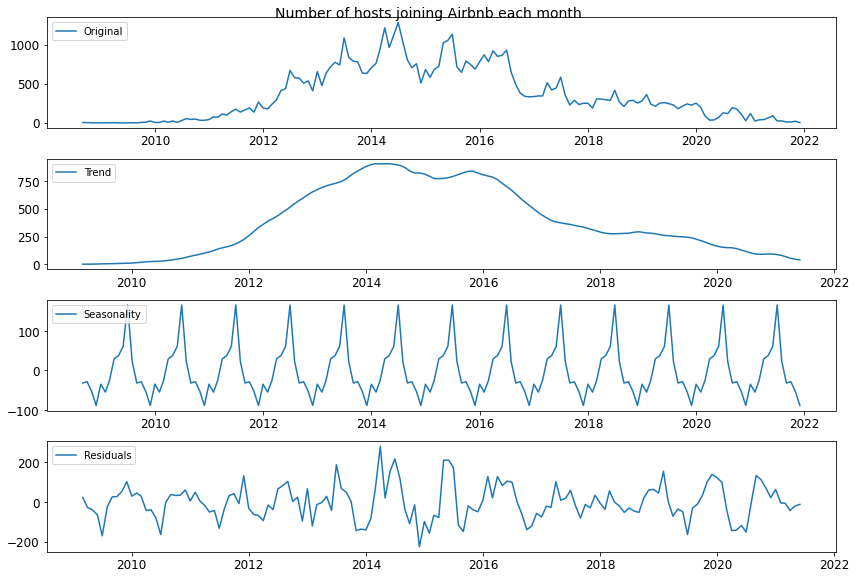

In [ ]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

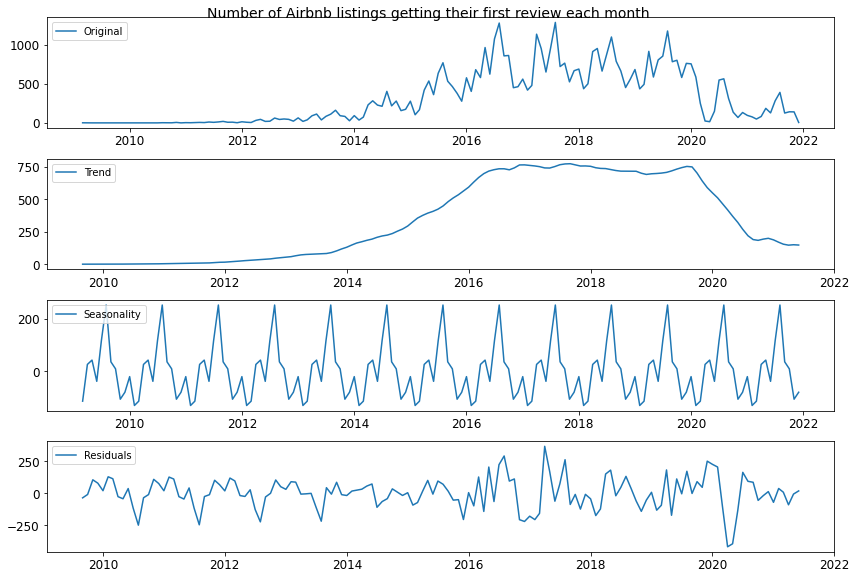

In [ ]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

### *Question: how have prices changed over time?*



Answer: the average price per night for Airbnb listings in Amsterdam has increased slightly over the last 12 years. In particular, the top end of property prices has increased, resulting in a larger increase in the mean price compared to the median - e.g. the mean price in 2015 was £95.90, whereas the mean price in 2018 (the last complete year of data) was £111.14.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


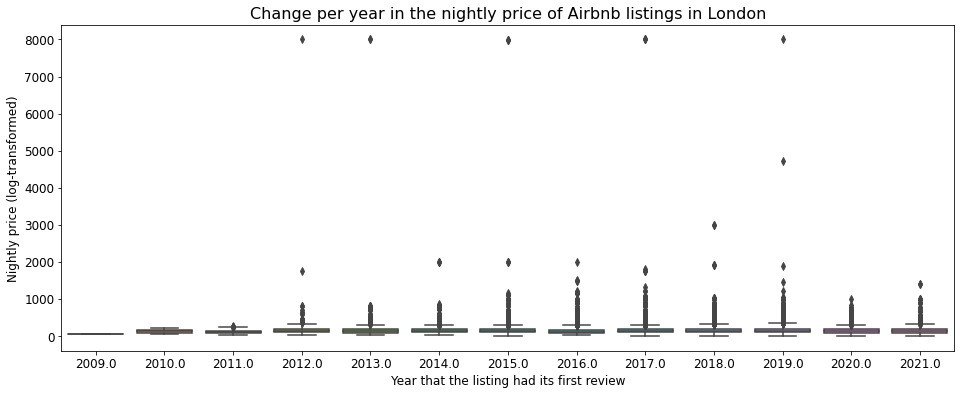

In [ ]:
plt.figure(figsize=(16,6))
sns.boxplot(listings.first_review.dt.year, listings.price)
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in Amsterdam', fontsize=16)
plt.show()

In [ ]:
print("Mean nightly price of listings in each year on Airbnb in Amsterdam:")
print(round(listings.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in Amsterdam:
first_review
2009-01-01     59.00
2010-01-01    123.67
2011-01-01    123.62
2012-01-01    187.70
2013-01-01    171.63
2014-01-01    150.89
2015-01-01    153.28
2016-01-01    143.80
2017-01-01    152.34
2018-01-01    155.35
2019-01-01    161.23
2020-01-01    147.81
2021-01-01    155.03
Name: price, dtype: float64


In [ ]:
# Dropping host_since and first_review as they are no longer needed
listings.drop(['host_since', 'first_review'], axis=1, inplace=True)

## Numerical Features

### Price

#### *Question: what is the overall distribution of prices?*

Answer: nightly advertised prices range from £0 to £13,700. The extreme ends of the range are due to hosts not understanding how to use Airbnb advertised prices (sometimes called 'sticker' prices) correctly. The advertised prices can be set to any arbitrary amount, and these are the prices that show when dates are not entered on the site.

A model is only as good as its data, and unfortunately this model will be predicting advertised prices rather than the prices actually paid. Nevertheless, some cleaning of the particularly unhelpful values will be done. Very small values under £10 will be increased to £10.

There are notable drop-offs in nightly prices at £200 (first graph, orange line), £500 (second graph, orange line) and £1,000 (second graph, red line). Values above £1,000 will  be reduced to £1,000.

In [ ]:
print(f"Nightly advertised prices range from ${min(listings.price)} to ${max(listings.price)}.")

Nightly advertised prices range from $0.0 to $8000.0.


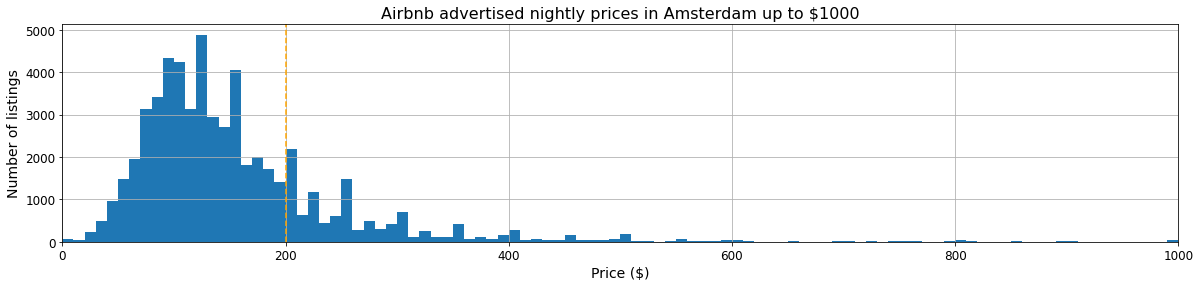

In [ ]:
# Distribution of prices from $0 to $1000
plt.figure(figsize=(20,4))
listings.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in Amsterdam up to $1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

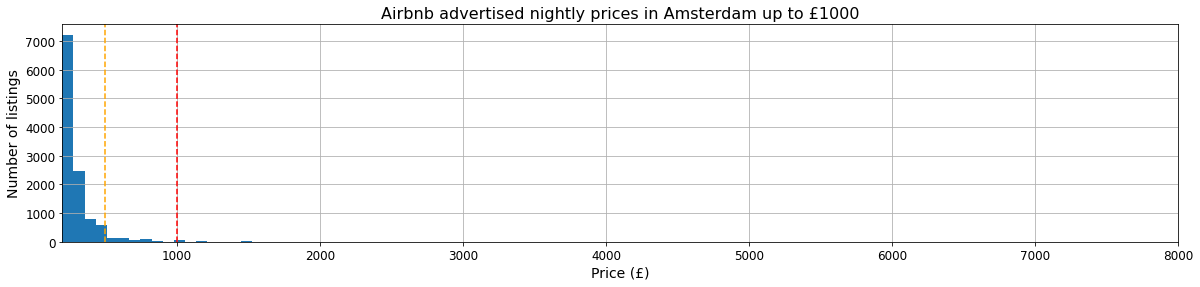

In [ ]:
# Distribution of prices from £200 upwards
plt.figure(figsize=(20,4))
listings  .price.hist(bins=100, range=(200, max(listings  .price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Amsterdam up to £1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

In [ ]:
# Replacing values under $10 with $10
listings.loc[listings.price <= 10, 'price'] = 10

# Replacing values over $1000 with $1000
listings.loc[listings.price >= 1000, 'price'] = 1000

### **Host listings count**

#### *Question: how many listings do hosts have on average? How many multi-listing hosts are there?*



Answer: 

In [ ]:
print("Median number of listings per host:", int(listings.host_listings_count.median()))
print("Mean number of listings per host:", int(round(listings.host_listings_count.mean())))
print(f"{int(round(100*len(listings[listings.host_listings_count == 1])/len(listings)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 2
67% of listings are from hosts with one listing.


### **Number of people accommodated, bathrooms, bedrooms and beds**

#### *Question: what are the average number of people accommodated, bathrooms, bedrooms and beds in Airbnb listings in Amsterdam, and how do prices differ?*



Answer: the most common property setup sleeps two people in one bed in one bedroom, with one bathroom. Unsurprisingly, properties that accommodate more people achieve noticeably higher nightly rates, with diminishing returns coming after about 10 people.

Some properties have very high looking values for some features (e.g. one property claims to have 17 bathrooms), but these will be left for now in the interests of time (as double-checking them would be time-consuming).

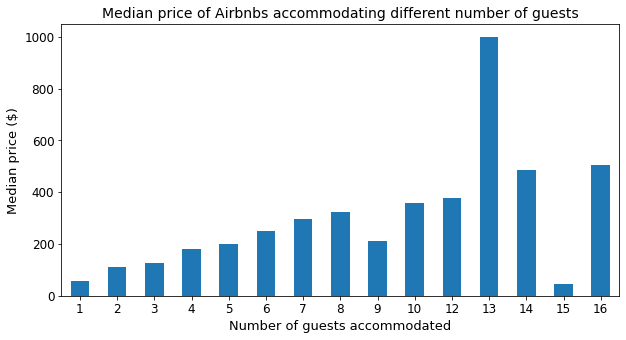

In [ ]:
plt.figure(figsize=(10,5))
listings.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

## Categorical Features

### **Neighbourhood**

#### *Question: which areas have the most Airbnb properties, and which are the most expensive?* 

In [ ]:
import geopandas as gpd
# Renaming the neighbourhood column
listings.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

# Importing the London borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('/content/drive/MyDrive/airbnb/neighbourhoods.geojson')
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Bijlmer-Oost,None,"MULTIPOLYGON Z (((4.99167 52.32444 43.06929, 4..."
1,Noord-Oost,None,"MULTIPOLYGON Z (((5.07916 52.38865 42.95663, 5..."
2,Noord-West,None,"MULTIPOLYGON Z (((4.93072 52.41161 42.91539, 4..."
3,Oud-Noord,None,"MULTIPOLYGON Z (((4.95242 52.38983 42.95411, 4..."
4,IJburg - Zeeburgereiland,None,"MULTIPOLYGON Z (((5.03906 52.35458 43.01664, 5..."


In [ ]:
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(listings.groupby('borough').size())
borough_df.rename(columns={0: 'number_of_listings'}, inplace=True)
borough_df['median_price'] = listings.groupby('borough').price.median().values

# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)

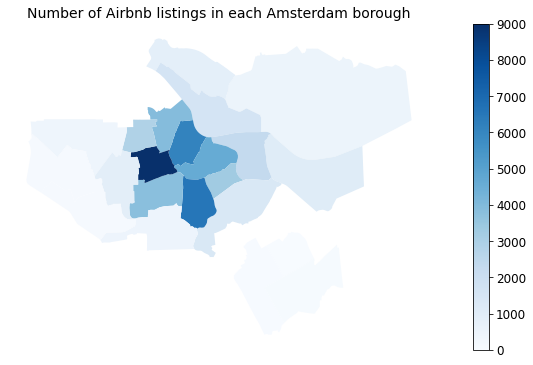

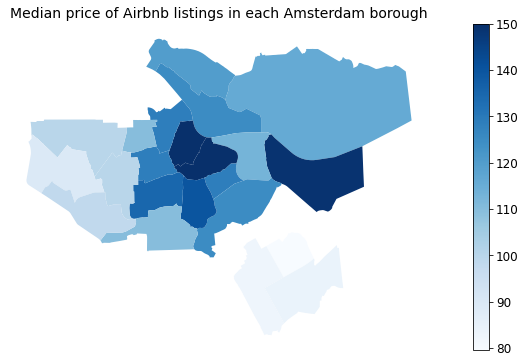

In [ ]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Amsterdam borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Amsterdam borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

### **Property and room types**

#### *Question: what are the most common property and room types?*

In [ ]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    listings[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

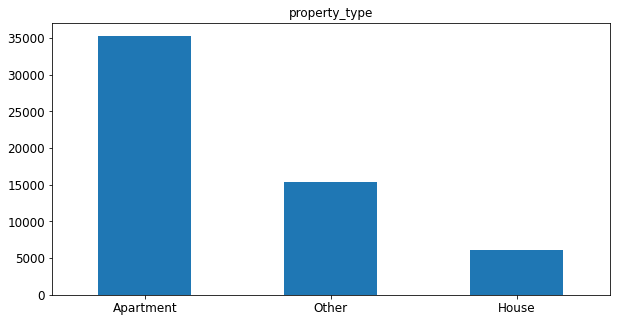

Apartment    0.622029
Other        0.271373
House        0.106599
Name: property_type, dtype: float64


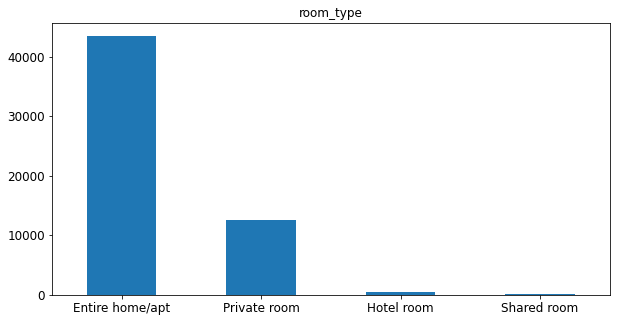

Entire home/apt    0.767052
Private room       0.222402
Hotel room         0.007724
Shared room        0.002821
Name: room_type, dtype: float64


In [ ]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(10,5))
    print(listings[col].value_counts(normalize=True))

### **Reviews**

#### *Question: what is the distribution of reviews like?*

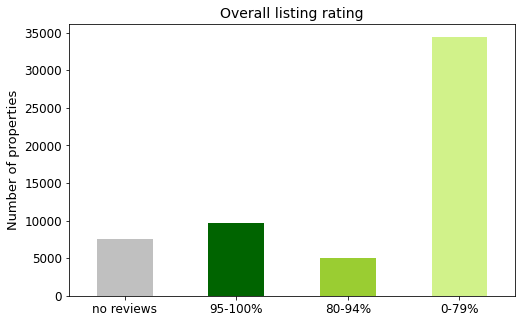

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Overall listing rating', fontsize=14)
listings['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['silver', 'darkgreen', 'yellowgreen', '#d1f28a' ], ax=ax)
ax.set_xticklabels(labels=['no reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Number of properties', fontsize=13)
plt.show()

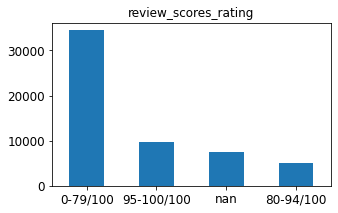

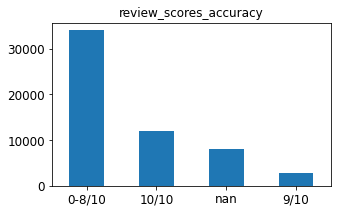

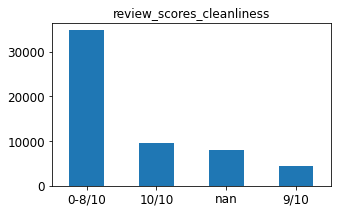

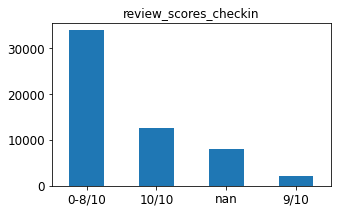

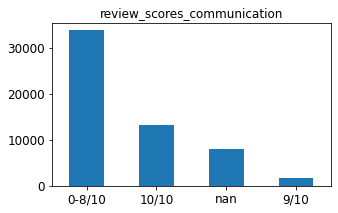

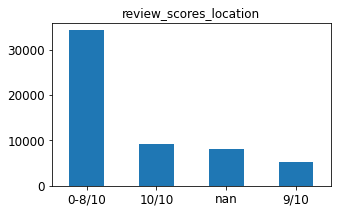

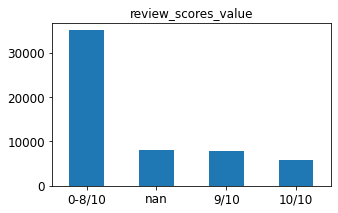

In [ ]:
for col in list(listings.columns[listings.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

### **First and last reviews**

#### *Question: how long have listings been on the site, and how many listings have been reviewed recently?*

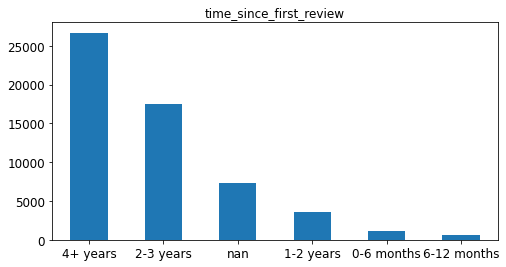

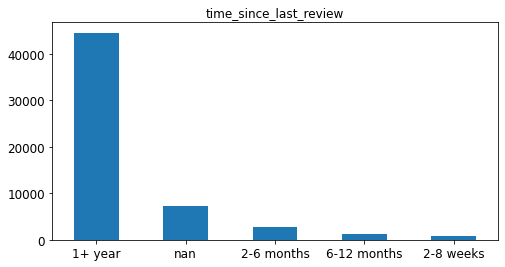

In [ ]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

## Boolean Features

In [ ]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    listings.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    listings.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price ($)')
    ax2.set_xlabel('')
    
    plt.show()

### **Superhosts**
*whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb*

#### *Question: what proportion of Airbnb hosts are superhosts, and is it worth being one? (a question often asked by hosts)*



Answer: about 14% of hosts are superhosts. However, it does not seem to improve the median price per night of their Airbnb listings, so it is arguable whether or not it is worth it (from a purely financial perspective).

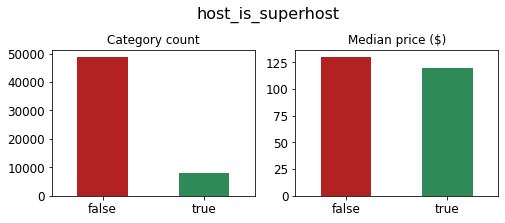

0.0    0.860531
1.0    0.139469
Name: host_is_superhost, dtype: float64


In [ ]:
binary_count_and_price_plot('host_is_superhost')
print(listings.host_is_superhost.value_counts(normalize=True))

### **Host verification**
*whether or not the host has been verified with id*

#### *Question: how many hosts are verified, and is it worth it? (a question often asked by hosts)*



Answer: only about 67% of hosts are verified (e.g. by providing ID and verifying your phone number and email address), although it is something that hosts often think they are expected to do. Interestingly, however, despite the fact that one might expect the additional trust commanded by verified hosts to result in higher nightly prices, there is no discernable difference between the median nightly prices of listings with verified and unverified hosts. This column will be left in the dataframe, however, in case it has any useful interactions with other features.

In [ ]:
listings.host_identity_verified.value_counts(normalize=True)

1.0    0.673238
0.0    0.326762
Name: host_identity_verified, dtype: float64

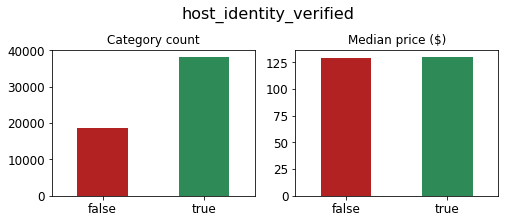

In [ ]:
binary_count_and_price_plot('host_identity_verified')

### **Instant booking**
*whether or not the property can be instant booked (i.e. booked straight away, without having to message the host first and wait to be accepted)*

#### *Question: how many properties are instant bookable (i.e. able to be booked without messaging the host first), and is it worth it?*



Answer: only about 24% of properties are instant bookable. However, the added convenience does not seem to have any effect on the median price per night.

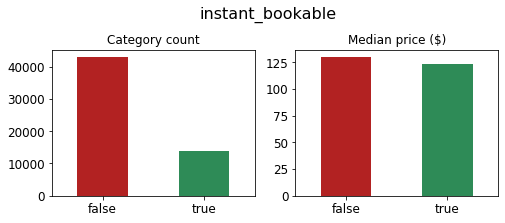

0    0.7576
1    0.2424
Name: instant_bookable, dtype: float64


In [ ]:
binary_count_and_price_plot('instant_bookable')
print(listings.instant_bookable.value_counts(normalize=True))

### **Amenities**

#### *Question: which amenities are common, and which increase the price of an Airbnb listing?*



Answer: amenities can be split into four main groups:

Uncommon, but properties with it have a higher median price:
- Balcony
- Coffee machine
- Basic cooking equipment
- Child friendly
- White good
- Private entrance
- Parking 
- Greeted by host

Most properties have it, and properties with it have a higher median price:
- TV

Most properties have it, and there is no major difference in price between properties with and without it:
- Internet
- Bed linen
- Long term stays allowed

Uncommon, and properties with it have a lower median price:
- Nothing

The takeaway from this is that there are some things that Airbnb hosts can do to try and improve their listing's price:
- **Make sure you have the necessities that your competitors also have**, e.g. internet, a TV and white goods (a washer, dryer and/or dishwasher).
- If you can, **include some extras to make your property stand out and achieve a higher price**. For example, you could buy a coffee machine, allow self check-in and long-term stays, and make your property child-friendly.
- **Avoid pets** as the additional wear and tear to your property might harm its financial performance.

In [ ]:
listings.iloc[:,27:-2].columns

Index(['instant_bookable', 'host_days_active', 'balcony', 'bed_linen', 'tv',
       'coffee_machine', 'cooking_basics', 'white_goods', 'child_friendly',
       'parking', 'host_greeting', 'internet', 'long_term_stays',
       'private_entrance'],
      dtype='object')

In [ ]:
for col in listings.iloc[:,27:-2].columns:
    binary_count_and_price_plot(col, figsize=(6,2))

# Data Preparation for Modeling

## Drop features

In [ ]:
transformed_df = pd.get_dummies(listings)

In [ ]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

In [ ]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

In [ ]:
transformed_df = transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('borough')]), axis=1)

In [ ]:
transformed_df = transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood')]), axis=1)

In [ ]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

Areas of multi-collinearity:

- There are perfect correlations between NaN reviews (i.e. listings that are not reviewed yet) for different review categories, and first and last review times. NaN categories can therefore be dropped.
- The same is true of unknown host response rates and times. One of these (rate) will be dropped.
- There is a correlation between a 0-49% response rate, and an average response time of a few days or more. One of these (rate) will be dropped.
- There are strong negative correlations between houses and apartments, and between private rooms and entire homes (as these were the main two categories of their features before they were one-hot encoded). Although these are important categories, one of each will be dropped in order to reduce multi-collinearity (apartments and private rooms, as these are the second most common categories).

In [ ]:
# Dropping collinear features
to_drop = [
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

In [ ]:
transformed_df.drop(to_drop, axis=1, inplace=True)

In [ ]:
transformed_df.columns

## Standardising and normalising

Other than availability_90 and host_days_active, the remaining numerical features are all postively skewed and could benefit from log transformation.

In [ ]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms',  
                     'host_days_active', 'host_listings_count',
                     'maximum_nights', 'minimum_nights',                  
                     'number_of_reviews', 'price']

In [ ]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [ ]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

In [ ]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [ ]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [ ]:
X.shape

In [ ]:
y.shape

# Train Model

## Train test split

In [ ]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)
print(X_test.shape)

## Select Model and Train

### XGBoost

In [ ]:
from sklearn.metrics import accuracy_score
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

In [ ]:
xgb_scores = (-cross_val_score(xgb_reg, X_train, y_train,cv=10, scoring='neg_mean_absolute_error'))
xgb_scores.mean()

### SVM Regressior

In [ ]:
from sklearn.svm import LinearSVR

svr_reg_start = time.time()
svr = LinearSVR(max_iter=10000)

svr.fit(X_train, y_train)
#predicting on the train set
y_pred_train = svr.predict(X_train)
y_pred_test = svr.predict(X_test)

svr_reg_end = time.time()

print(f"Time taken to run: {round((svr_reg_end - svr_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, y_pred_train),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_pred_test),4))
print("\nTraining r2:", round(r2_score(y_train, y_pred_train),4))
print("Validation r2:", round(r2_score(y_test, y_pred_test),4))


In [ ]:
svr_scores = (-cross_val_score(svr, X_train, y_train,cv=10, scoring='neg_mean_absolute_error'))
svr_scores.mean()

### Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

#instantiate
gbrt_reg_start = time.time()

gbrt = GradientBoostingRegressor()

gbrt.fit(X_train, y_train)

# train set
y_pred_train = gbrt.predict(X_train)
y_pred_test = gbrt.predict(X_test)

gbrt_reg_end = time.time()

print(f"Time taken to run: {round((gbrt_reg_end - gbrt_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, y_pred_train),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_pred_test),4))
print("\nTraining r2:", round(r2_score(y_train, y_pred_train),4))
print("Validation r2:", round(r2_score(y_test, y_pred_test),4))

In [ ]:
gbrt_scores = (-cross_val_score(gbrt, X_train, y_train,cv=10, scoring='neg_mean_absolute_error'))
gbrt_scores.mean()

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor 

# Istantiate

forest_reg_start = time.time()
forest_reg = RandomForestRegressor(n_jobs=-1) 
# Fit
forest_reg.fit(X_train, y_train)
# predict on the train set
y_pred_train = forest_reg.predict(X_train)
y_pred_test = forest_reg.predict(X_test)

forest_reg_end = time.time()

print(f"Time taken to run: {round((forest_reg_end - forest_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, y_pred_train),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_pred_test),4))
print("\nTraining r2:", round(r2_score(y_train, y_pred_train),4))
print("Validation r2:", round(r2_score(y_test, y_pred_test),4))

In [ ]:
forest_reg_scores = (-cross_val_score(forest_reg, X_train, y_train,cv=10, scoring='neg_mean_absolute_error'))
forest_reg_scores.mean()

#### RF tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
# Parameters
n_estimators = randint(60, 105)
max_features = uniform(0, 1)
max_depth = [8,11,12,13]
# Istantiate
forest_rig_model = RandomForestRegressor(random_state=42)
# making a dictionary with a list of values of possible parameters
param_dist = dict(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)
# n_iter controls the number of searches 

rand = RandomizedSearchCV(forest_rig_model, # our model that we used 
                          param_dist, # dictionary containing the list possible paramaters
                          cv=4, # number of cross validation folds 
                          scoring='neg_mean_absolute_error', 
                          n_iter=7, # Number of itterations
                          random_state=42, 
                          verbose=10, 
                          n_jobs=-1) # use all the available cores
# fit the model
rand.fit(X_train, y_train)

In [ ]:
print(-rand.best_score_) # Gives the score that we specified in the model
print(rand.best_params_) # gives the best possible combination of parameters that we passed in the dictionary
print(rand.best_estimator_) # It contains best values values of all the parameters

In [ ]:
# Istantiate 
forest_start = time.time()

forest = rand.best_estimator_
# fit
forest.fit(X_train, y_train)
# predict on X_train
y_pred_train = forest.predict(X_train)
y_pred_test = forest.predict(X_test)

forest_end = time.time()

print(f"Time taken to run: {round((forest_end - forest_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, y_pred_train),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_pred_test),4))
print("\nTraining r2:", round(r2_score(y_train, y_pred_train),4))
print("Validation r2:", round(r2_score(y_test, y_pred_test),4))

In [ ]:
  # STill high Variance 
  forest_scores = (-cross_val_score(
                          forest, 
                          X_train, y_train,
                          cv=10, scoring='neg_mean_absolute_error'))
  forest_scores.mean()

## Final Pick

### Mean Square Error

In [ ]:
fig = plt.figure(figsize=(10, 4), facecolor= '#dadada', dpi=500)

plt.plot([1]*10, forest_scores, ".")
plt.plot([2]*10, gbrt_scores, ".")
plt.plot([3]*10, svr_scores, ".")
plt.plot([4]*10, xgb_scores, ".")

plt.boxplot([forest_scores, gbrt_scores, svr_scores,xgb_scores], 
            labels=("Hyper-Tuned Random Forest", 'Gradient Boost', 'Support Vector Machines','XGBoost Regression'))

plt.ylabel("Mean Absolute Error", fontsize=14)
plt.title('Algorithm Comparison')


# Remove the splines 
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.tight_layout() # Makes it better looking specially on laptops

# to save the fig
#fig.savefig('algcomparison.png',bbox_inches='tight', dpi=500, facecolor = '#dadada')

plt.show()

### R2 Score

In [ ]:
forest_r2_score = r2_score(y_test, forest.predict(X_test))
gbrt_r2_score = r2_score(y_test, gbrt.predict(X_test))
svr_r2_score = r2_score(y_test, svr.predict(X_test))
xgb_r2_score = r2_score(y_test, xgb_reg.predict(X_test))

In [ ]:
fig = plt.figure(figsize=(10, 4), facecolor= '#dadada', dpi=500)

data = {'Hyper-Tuned Random Forest':forest_r2_score, 
        'Gradient Boost':gbrt_r2_score, 
        'Support Vector Machines':svr_r2_score,
        'XGBoost Regression':xgb_r2_score}

courses = list(data.keys())
values = list(data.values())

plt.bar(courses, values,color=['silver', 'darkgreen', 'yellowgreen', '#d1f28a' ], width = 0.4)

plt.ylabel("R Squared Score", fontsize=14)
plt.title('Algorithm Comparison on Test data')


# Remove the splines 
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.tight_layout() # Makes it better looking specially on laptops

# to save the fig
#fig.savefig('algcomparison.png',bbox_inches='tight', dpi=500, facecolor = '#dadada')

plt.show()

# Explained Model 

The SHAP framework has proved to be an important advancement in the field of machine learning model interpretation. It combines several existing methods to create an intuitive, theoretically-sound approach to explain predictions for any model.

In [ ]:
!pip install shap

In [ ]:
import shap

explainer = shap.TreeExplainer(forest)

shap_values = explainer.shap_values(X_test.iloc[100])
features = X_test.columns

SHAP builds model explanations by asking the same question for every prediction and feature: “How does prediction I change when feature j is removed from the model?” So-called SHAP values are the answers. They quantify the magnitude and direction (positive or negative) of a feature’s effect on a prediction.


In [ ]:
shap.initjs()

shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=features
)

## *Question: Search factors affecting the rise in prices*

In [ ]:
from sklearn.inspection import permutation_importance
pi = permutation_importance(forest, X_train, y_train, n_jobs=-1)

In [ ]:
# making a dataframe 
data = {'importances_mean': np.round(pi['importances_mean'], 4),
        'importances_std': pi['importances_std']}

pi_df = pd.DataFrame(data, index=features).sort_values(by='importances_mean', ascending=False)
                     
pi_df.head(10)

In [ ]:
fig = plt.figure(figsize=(8, 4), facecolor= '#dadada', dpi=100)
# plotting first 10 important features
pi_df['importances_mean'].tail(10).plot(kind='barh')
 
plt.xticks([])
plt.title("Top 10 Features affecting the rise in price", fontsize=14)
plt.xlabel("Feature importance")

# Remove the splines 
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.tight_layout() # Makes it better looking specially on laptops

# to save the fig
#fig.savefig('timeseriesplot.jpg',bbox_inches='tight', dpi=100, facecolor = '#dadada')

plt.show()

**The top 10 most important features are:**
- How many people the property accommodates
- The cleaning fee
- How many other listings the host has (and whether they are a multi-listing host)
- How many days are available to book out of the next 90
- The fee per extra person
- The number of reviews
- The number of bathrooms
- The security deposit
- If the property is in Westminster
- The minimum nights stay



# Other Questions

## *Question: Find the Peak Season and Off Season for the year 2021*

In [ ]:
calendar.head()

In [ ]:
calendar.dtypes

In [ ]:
np.sum(calendar.isna())

In [ ]:
# changing the date to only the month
calendar['date'] = calendar.date.str.replace(r'(^.*2021-03-.*$)', 'march')
calendar['date'] = calendar.date.str.replace(r'(^.*2021-04-.*$)', 'april')
calendar['date'] = calendar.date.str.replace(r'(^.*2021-05-.*$)', 'may')
calendar['date'] = calendar.date.str.replace(r'(^.*2021-06-.*$)', 'june')
calendar['date'] = calendar.date.str.replace(r'(^.*2021-07-.*$)', 'july')
calendar['date'] = calendar.date.str.replace(r'(^.*2021-08-.*$)', 'august')
calendar['date'] = calendar.date.str.replace(r'(^.*2021-09-.*$)', 'septemer')
calendar['date'] = calendar.date.str.replace(r'(^.*2021-10-.*$)', 'october')
calendar['date'] = calendar.date.str.replace(r'(^.*2021-11-.*$)', 'november')
calendar['date'] = calendar.date.str.replace(r'(^.*2021-12-.*$)', 'december')

In [ ]:
calendar['adjusted_price'] = calendar['adjusted_price'].str.replace(',', '')
calendar['adjusted_price'] = calendar['adjusted_price'].str.replace('$', '')
calendar['adjusted_price'] = calendar['adjusted_price'].astype(float)

In [ ]:
del calendar["price"]
del calendar["available"]
del calendar["minimum_nights"]
del calendar["maximum_nights"]

In [ ]:
# creating a new dataframe where I'm grouping the date column i.e. monthwise
# and further calculating the average of the price

month_price_avg = calendar.groupby(['date']).mean()['adjusted_price']

In [ ]:
# reindexing as per the month names

month_price_avg = month_price_avg.reindex(index=['march', 'april', 'may', 'june', 'july',
                                                'august', 'septemer', 'october', 'november', 'december'])

In [ ]:
prices = list(month_price_avg)

In [ ]:
month_price_avg.index

In [ ]:
month_price_avg_df = pd.DataFrame(month_price_avg.index, prices)

In [ ]:
# renaming the date column to `month`

month_price_avg_df.columns = ['month']
month_price_avg_df.reset_index(inplace=True)
month_price_avg_df.columns = ['avg_price', 'month']
# re-ordering the columns

month_price_avg_df = month_price_avg_df[['month', 'avg_price']]

In [ ]:
month_price_avg_df

In [ ]:
# plotting a barplot for number of missing values versus the columns

plt.plot(month_price_avg_df.month, month_price_avg_df.avg_price);
plt.xticks(rotation=45);
plt.xlabel("Months");
plt.ylabel("Average Price in USD");

#### Answer
The graph shows changes in the average price in Amsterdam since March 2021, and the trends until the end of the year.

The price stood at `154$` at the start of this period `(March 2021)` and then the rate has fluctuated between `157$ and 159$` in `May to July`. Finally the price is rapidly increasing to the peak of price with `164$` in December 2021 



## *Question: Find the Top Hosts based on User Reviews*

In [ ]:
review.head()

In [ ]:
review.shape

In [ ]:
print("Null values:", review.comments.isna().sum())
print(f"Proportion: {round((review.comments.isna().sum()/len(review))*100, 1)}%")

In [ ]:
review = review.dropna()

In [ ]:
# ! pip install nltk
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [ ]:
# function to calculate the sentiments of the user reviews
def nltk_sentiment(input_text):
    score_dict = sid.polarity_scores(input_text)
    return score_dict['compound']

In [ ]:
review['Sentiment_NLTK'] = review['comments'].apply(lambda x: nltk_sentiment(str(x)))

In [ ]:
review_avg = review.groupby(['listing_id']).mean()['Sentiment_NLTK']

In [ ]:
# The top 5 hosts:

review_avg.nlargest()

In [ ]:
# creating a top_hosts dataframe

top_hosts = pd.DataFrame()
listing_ids = list(review_avg.nlargest().index)
for idx in listing_ids:
    top_hosts = top_hosts.append(listings[listings.id==idx])
top_hosts.reset_index(inplace=True)
del top_hosts['index']

In [ ]:
# finding the names of top hosts' property
top_hosts.host_name.unique()

### Answer

Top 5 highest rated hosts:
- Laila
- Sevi
- Karen
- Joren
- Emelie

# Potential directions for future work

- Find a way to incorporate image quality into the model, e.g. by using the output of a convolutional neural network to assess image quality as an input into the pricing model 
- Use better quality/more accurate data which includes the actual average prices paid per night
- Include a wider geographic area, e.g. the rest of the UK or other major cities around the world
- Augment the model with natural language processing (NLP) of listing descriptions and/or reviews, e.g. for sentiment analysis or looking for keywords
- In addition to predicting base prices, a sequence model could be created to calculate daily rates using data on seasonality and occupancy, which would allow the creation of actual pricing software
- Tailor the model more specifically to new listings in order to help hosts set prices for new properties, by removing features that would not be known at the time - e.g. other fees, availability and reviews